# Thesis Work - Jan 2 - Xception

## Importing Necessary Libraries

In [1]:
import os
import random
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Loading the Dataset's Kaggle Path

In [2]:
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download(
    "wasifmahmood01/custom-waste-classification-dataset"
)

print("Dataset downloaded to:", path)

100%|██████████| 5.39G/5.39G [04:19<00:00, 22.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1


In [3]:
for root, dirs, files in os.walk(path):
    print(root)
    break

/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1


In [4]:
for d in os.listdir(path):
    print(d)

wastes


In [5]:
data_dir = Path(path) / "wastes"

train_dir = data_dir / "train"
test_dir  = data_dir / "test"

print("Train exists:", train_dir.exists())
print("Test exists:", test_dir.exists())

Train exists: True
Test exists: True


## Adding Generators

In [8]:
# Dataset directory paths (ADJUST ONLY IF YOUR FOLDER NAMES DIFFER)

TRAIN_DIR = "/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/train"
VAL_DIR   = "/root/.cache/kagglehub/datasets/wasifmahmood01/custom-waste-classification-dataset/versions/1/wastes/test"

import os
print("Train classes:", os.listdir(TRAIN_DIR))
print("Val classes:", os.listdir(VAL_DIR))

Train classes: ['automobile wastes', 'paper waste', 'metal waste', 'E-waste', 'organic waste', 'battery waste', 'light bulbs', 'glass waste', 'plastic waste']
Val classes: ['automobile wastes', 'paper waste', 'metal waste', 'E-waste', 'organic waste', 'battery waste', 'light bulbs', 'glass waste', 'plastic waste']


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes

Found 9214 images belonging to 9 classes.
Found 2308 images belonging to 9 classes.


In [10]:
print("Class indices:")
for k, v in train_gen.class_indices.items():
    print(f"{v}: {k}")

Class indices:
0: E-waste
1: automobile wastes
2: battery waste
3: glass waste
4: light bulbs
5: metal waste
6: organic waste
7: paper waste
8: plastic waste


## Build & Train Xception Model

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
)
from tensorflow.keras.models import Model

base_model = Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(299, 299, 3)
)

# Freeze all backbone layers initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = Dense(
    256,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)

x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 21,396,529 (81.62 MB)

 Trainable params: 530,953 (2.03 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [14]:
history_frozen = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.6040 - loss: 1.4552 - val_accuracy: 0.8349 - val_loss: 0.5787 - learning_rate: 0.0010
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.7681 - loss: 0.8013 - val_accuracy: 0.8462 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8036 - loss: 0.6708 - val_accuracy: 0.8536 - val_loss: 0.5471 - learning_rate: 0.0010
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8363 - loss: 0.5550 - val_accuracy: 0.8605 - val_loss: 0.5094 - learning_rate: 0.0010
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8380 - loss: 0.5468 - val_accuracy: 0.8718 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8464 - loss: 0.5228 - val_accuracy: 0.8744 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8535 - loss: 0.

In [19]:
frozen_train_acc = max(history_frozen.history['accuracy'])
frozen_val_acc = max(history_frozen.history['val_accuracy'])

print(f"Best Frozen Train Accuary: {frozen_train_acc*100:.2f}%")
print(f"Best Frozen Validation Accuary:   {frozen_val_acc*100:.2f}%")

Best Frozen Train Accuary: 86.53%
Best Frozen Validation Accuary:   88.47%


In [18]:
# Extracting the final epoch values instead of the maximums
frozen_train_final_acc = history_frozen.history['accuracy'][-1]
frozen_val_final_acc = history_frozen.history['val_accuracy'][-1]

# print(f"Final Frozen Train Accuary: {frozen_train_final_acc*100:.2f}%")
# print(f"Final Frozen Validation Accuary:   {frozen_val_final_acc*100:.2f}%")

73/73 ━━━━━━━━━━━━━━━━━━━━ 62s 688ms/step
Frozen Xception Model Classification Report:
                   precision    recall  f1-score   support

          E-waste       0.86      0.91      0.88       313
automobile wastes       0.91      0.89      0.90       218
    battery waste       0.92      0.88      0.90       213
      glass waste       0.90      0.91      0.90       256
      light bulbs       0.85      0.87      0.86       105
      metal waste       0.88      0.86      0.87       308
    organic waste       0.90      0.92      0.91       223
      paper waste       0.91      0.90      0.91       343
    plastic waste       0.84      0.83      0.83       329

         accuracy                           0.88      2308
        macro avg       0.89      0.89      0.89      2308
     weighted avg       0.88      0.88      0.88      2308



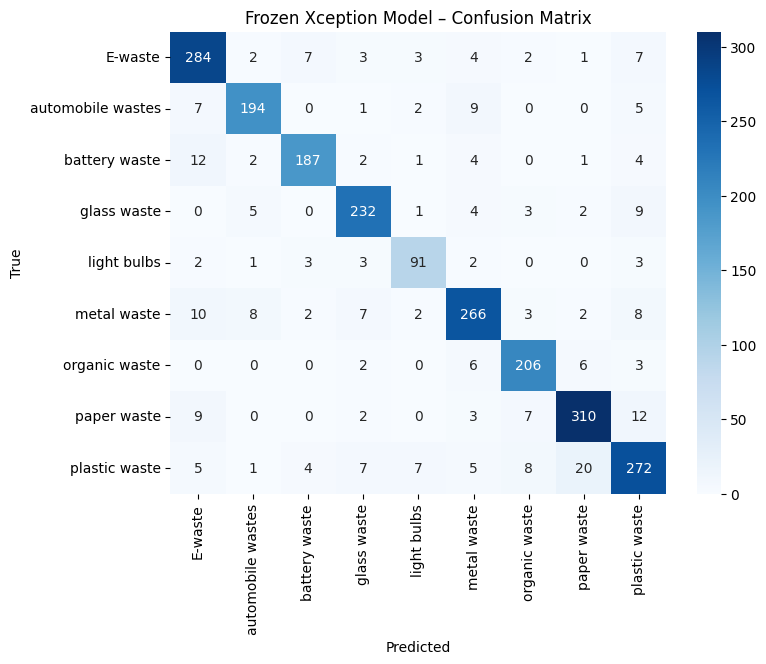

In [20]:
val_gen.reset()
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Frozen Xception Model Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys())
plt.title("Frozen Xception Model – Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [21]:
y_pred_classes = np.argmax(y_pred, axis=1)

# calculate the F1 score using the converted labels
macro_f1 = f1_score(y_true, y_pred_classes, average="macro")

print(f"Final Macro F1 Score - Frozen Xception Model: {macro_f1:.4f}")

Final Macro F1 Score - Frozen Xception Model: 0.8850


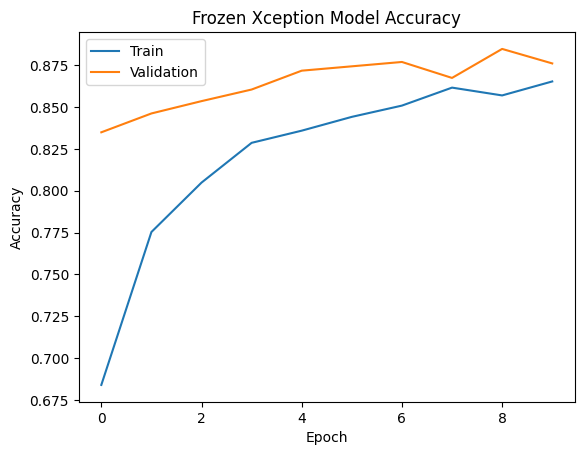

In [22]:
plt.plot(history_frozen.history["accuracy"], label="Train")
plt.plot(history_frozen.history["val_accuracy"], label="Validation")
plt.title("Frozen Xception Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Fine-Tuning Xception Model

While the frozen Xception model just achieved strong performance (e.g., Macro F1 = 0.885), fine-tuning was performed for completeness and to assess whether task-specific feature adaptation could further improve classification performance.

In [23]:
# Freeze everything
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze just the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [25]:
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8513 - loss: 0.5324 - val_accuracy: 0.8752 - val_loss: 0.5149 - learning_rate: 1.0000e-05
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8611 - loss: 0.5140 - val_accuracy: 0.8769 - val_loss: 0.5084 - learning_rate: 1.0000e-05
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8638 - loss: 0.4985 - val_accuracy: 0.8834 - val_loss: 0.4961 - learning_rate: 1.0000e-05
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.8819 - loss: 0.4432 - val_accuracy: 0.8878 - val_loss: 0.4869 - learning_rate: 1.0000e-05
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8906 - loss: 0.4126 - val_accuracy: 0.8925 - val_loss: 0.4742 - learning_rate: 1.0000e-05
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.8942 - loss: 0.3870 - val_accuracy: 0.8938 - val_loss: 0.4669 - learning_rate: 1.0000e-05
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - acc

In [26]:
ft_train_acc = max(history_finetune.history['accuracy'])
ft_val_acc = max(history_finetune.history['val_accuracy'])

print(f"Best Fine-Tuned Train Accuary: {ft_train_acc*100:.2f}%")
print(f"Best Fine-Tuned Validation Accuary:   {ft_val_acc*100:.2f}%")

Best Fine-Tuned Train Accuary: 91.68%
Best Fine-Tuned Validation Accuary:   90.08%


73/73 ━━━━━━━━━━━━━━━━━━━━ 62s 687ms/step
Fine-Tuned Xception Model Classification Report:
                   precision    recall  f1-score   support

          E-waste       0.89      0.91      0.90       313
automobile wastes       0.88      0.91      0.90       218
    battery waste       0.92      0.92      0.92       213
      glass waste       0.95      0.89      0.92       256
      light bulbs       0.88      0.88      0.88       105
      metal waste       0.87      0.88      0.87       308
    organic waste       0.93      0.94      0.94       223
      paper waste       0.95      0.91      0.93       343
    plastic waste       0.85      0.87      0.86       329

         accuracy                           0.90      2308
        macro avg       0.90      0.90      0.90      2308
     weighted avg       0.90      0.90      0.90      2308



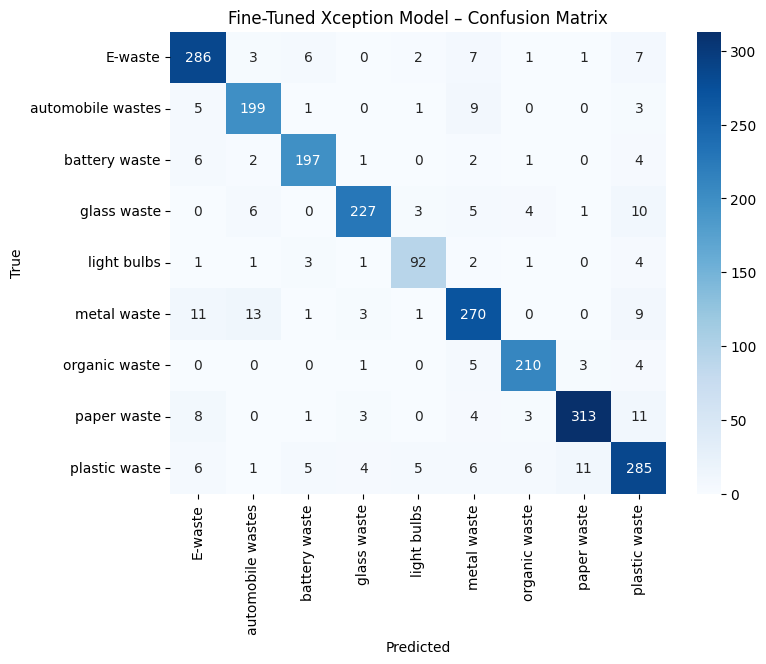

In [27]:
val_gen.reset()
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Fine-Tuned Xception Model Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys())
plt.title("Fine-Tuned Xception Model – Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [28]:
y_pred_classes = np.argmax(y_pred, axis=1)

# calculate the F1 score using the converted labels
macro_f1 = f1_score(y_true, y_pred_classes, average="macro")

print(f"Final Macro F1 Score - Fine-Tuned Xception Model: {macro_f1:.4f}")

Final Macro F1 Score - Fine-Tuned Xception Model: 0.9014


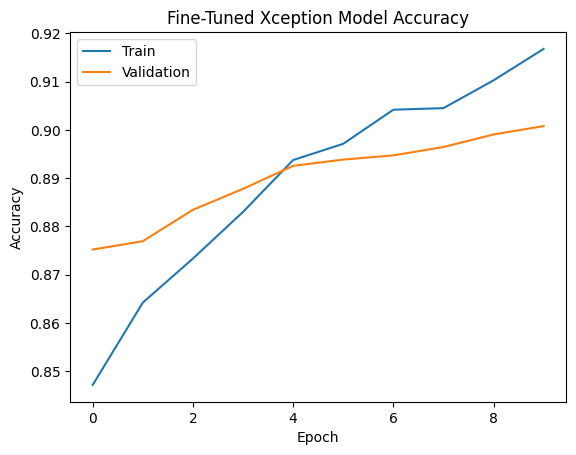

In [29]:
plt.plot(history_finetune.history["accuracy"], label="Train")
plt.plot(history_finetune.history["val_accuracy"], label="Validation")
plt.title("Fine-Tuned Xception Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Overall, to reduce/prevent overfitting, data augmentation, dropout, L2 regularization, and adaptive learning rate scheduling were employed. Fine-tuning was restricted to the final layers of the pretrained backbone with the use of a very small learning rate.